In [7]:
from utils import  load_data
from bert_format import input_format, position_ids_compute, format_time, flat_accuracy
import params
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from transformers import BertForSequenceClassification
import torch, pickle
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from torch import nn   
from multitask_format import MultiTaskModel, Task

device = torch.device(params.device)

test_data = load_data(params.data_path + "test_data.json", map_relations=params.map_relations)

num_labels = 18

attach_task = Task(id = 0, name = 'attach prediction', type = "seq_classification", num_labels=2)
relation_task = Task(id = 1, name = 'relation prediction', type = "seq_classification", num_labels = num_labels)
tasks = [attach_task, relation_task]

model = MultiTaskModel(params.model_name, tasks)
output_model = params.model_path + 'bert_multitask.pth'
print(output_model)
checkpoint = torch.load(output_model, map_location='cuda')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
print('loaded')

Loading data: data/stac_data/test_data.json
109 dialogs, 1156 edus, 1126 relations, 8 backward relations
77 edus have multiple parents


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


models/stac/bert_multitask5.pth
loaded


### Prediction on gold attachments

Predicting labels for 1,118 test sentences...
    DONE.
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       164
           1       0.37      0.52      0.43        44
           2       0.25      0.19      0.22        21
           3       0.92      0.83      0.87       305
           4       0.70      0.47      0.56        15
           5       0.71      0.79      0.75       148
           6       0.60      0.61      0.61       101
           7       0.43      0.61      0.51        33
           8       1.00      0.55      0.71        11
           9       0.50      0.54      0.52       113
          10       0.41      0.48      0.44        29
          11       0.50      0.57      0.53        30
          12       0.69      0.56      0.62        71
          13       1.00      0.79      0.88        19
          14       0.00      0.00      0.00        13
          15       0.00      0.00      0.00         1

    accuracy            

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


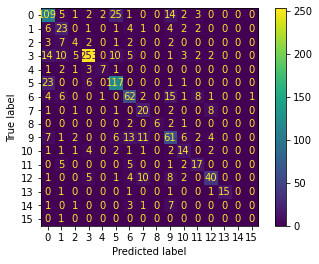

In [8]:
input_ids, attention_masks, token_type_ids, tokens, labels_relation, labels, raw = input_format(test_data, relations=True)
position_ids = position_ids_compute(input_ids, raw, labels)
task_ids = torch.Tensor([1 for i in range(len(input_ids))])

prediction_data = TensorDataset(input_ids, attention_masks, token_type_ids, position_ids, labels_relation, task_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=params.batch_size_bert)

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_token_types, b_position_ids, b_labels, b_task_ids = batch

    with torch.no_grad():
        outputs, embed = model(b_input_ids, 
                     token_type_ids=b_token_types, 
                     attention_mask=b_input_mask,
                     position_ids = b_position_ids,
                     task_ids = b_task_ids)
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    true_labels.append(label_ids)

print('    DONE.')

flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
print(classification_report(flat_true_labels,flat_predictions))

cm = confusion_matrix(flat_true_labels,flat_predictions)
ConfusionMatrixDisplay(cm).plot()

### Relation prediction on the predicted attachments

In [9]:
with open(params.data_path + 'linear_pred_stac.pkl', 'rb') as f:
    test_pred = pickle.load(f)
input_ids, attention_masks, token_type_ids, tokens, labels_attach, labels, raw = input_format(test_data, relations=True, attach_preds=test_pred)
position_ids = position_ids_compute(input_ids, raw, labels)
task_ids = torch.Tensor([1 for i in range(len(input_ids))])

prediction_data = TensorDataset(input_ids, attention_masks, token_type_ids, position_ids, task_ids)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=params.batch_size_bert)


model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_token_types, b_position_ids, b_task_ids = batch

    with torch.no_grad():
        outputs, embed = model(b_input_ids, 
                     token_type_ids=b_token_types, 
                     attention_mask=b_input_mask,
                     position_ids = b_position_ids,
                     task_ids = b_task_ids)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()

    predictions.append(logits)

print('    DONE.')

flat_prediction = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_prediction, axis=1).flatten()

    DONE.


In [10]:
counter = 0
for dialog in test_pred: 
    for pair in dialog:
        pair += [flat_predictions[counter]]
        counter += 1

# compute the f1 score
test_truth = []
for dialogue in test_data:
    truth = []
    if len(dialogue['edus'])==1:
        continue
    for edu in dialogue['relations']:
        tup = (edu['x'],edu['y'], edu['type'])
        truth += [tup]
    test_truth += [truth]

cnt_pred = []
for dialog in test_pred:
    cnt_pred += [len(dialog)+1]

cnt_pred = sum(cnt_pred)
print('nb of total predictions : ', cnt_pred)

cnt_golden = []
for i,dialog in enumerate(test_data):  
    cnt_g = len(dialog['relations'])
    cnt = [0] * len(dialog["edus"])
    for r in dialog["relations"]:
        cnt[r["y"]] += 1
    for j in range(len(dialog["edus"])):
        if cnt[j] == 0:
            cnt_g += 1
    cnt_golden += [cnt_g]
cnt_golden = sum(cnt_golden)
print('nb of relations : ',cnt_golden) 

cnt_correct = []
for i, dialog_pred in enumerate(test_pred):
    val = 0
    dialog_pred = [j for j in dialog_pred]
    truth = [j for j in test_truth[i]]
    for pred in dialog_pred : 
        if tuple(pred) in truth:
            val += 1
    cnt_correct += [val+1]
cnt_correct = sum(list(cnt_correct))
print('nb of correct predictions : ', cnt_correct)

precision = cnt_correct*1.0/cnt_pred*1.0
recall = cnt_correct*1.0/cnt_golden*1.0
print('precision : ', precision )
print('recall : ', recall)
print('F1 score : ' , 2*( precision * recall / (precision + recall)))

nb of total predictions :  1200
nb of relations :  1239
nb of correct predictions :  683
precision :  0.5691666666666667
recall :  0.5512510088781275
F1 score :  0.5600656006560066


## CSV output of the predictions

In [ ]:
import pandas as pd
df_pred = pd.DataFrame(columns = ['id','dialog_num','x_pred', 'y_pred', 'x_raw', 'y_raw','relation' ,'x_speaker','y_speaker'])#, 'relation_type'])
inv_relations = {v: k for k, v in params.map_relations.items()}

for i, (pred,data) in enumerate(zip(test_pred,test_data)):
    temp = pd.DataFrame()
    temp['id'] = [data['id'] for i in pred]
    temp['dialog_num'] = [i for t in range(len(pred))]
    temp['x_pred'] = [t[0] for t in pred ]
    temp['y_pred'] = [t[1] for t in pred ]
    temp['x_raw'] = [data['edus'][t[0]]['text_raw'] for t in pred]
    temp['y_raw'] = [data['edus'][t[1]]['text_raw'] for t in pred]
    temp['x_speaker'] = [data['edus'][t[1]]['speaker'] for t in pred]
    temp['y_speaker'] = [data['edus'][t[1]]['speaker'] for t in pred]
    temp['gold'] = [data['relations'] for t in pred]
    temp['relation'] = [t[2] for t in pred]
    temp['relation_type']=[inv_relations[t[2]] for t in pred]
    df_pred = pd.concat([df_pred,temp])
df_pred = df_pred.reset_index(drop= True)

In [7]:
df_pred.to_csv(params.data_path + 'predictions.csv')

,id,dialog_num,x_pred,y_pred,x_raw,y_raw,relation,x_speaker,y_speaker,gold,relation_type
0,pilot02,0,0,1,can I buy a sheep?,none,3,william,william,"[{'type': 3, 'x': 0, 'y': 1}, {'type': 3, 'x':...",QAP
1,pilot02,0,0,2,can I buy a sheep?,no sorry,3,Cat,Cat,"[{'type': 3, 'x': 0, 'y': 1}, {'type': 3, 'x':...",QAP
2,pilot02,0,1,3,none,ok,5,Thomas,Thomas,"[{'type': 3, 'x': 0, 'y': 1}, {'type': 3, 'x':...",Acknowledgement
3,pilot02,0,2,3,no sorry,ok,5,Thomas,Thomas,"[{'type': 3, 'x': 0, 'y': 1}, {'type': 3, 'x':...",Acknowledgement
4,pilot02,1,0,1,i've got too much wheat!,sheep again anyone?,10,Thomas,Thomas,"[{'type': 9, 'x': 0, 'y': 1}, {'type': 13, 'x'...",Result
...,...,...,...,...,...,...,...,...,...,...,...
1086,s2-league4-game2,108,8,10,No....,wheat,3,ztime,ztime,"[{'type': 7, 'x': 0, 'y': 1}, {'type': 6, 'x':...",QAP
1087,s2-league4-game2,108,10,11,wheat,I give wheat,6,ztime,ztime,"[{'type': 7, 'x': 0, 'y': 1}, {'type': 6, 'x':...",Elaboration
1088,s2-league4-game2,108,9,12,nope,ok,5,ztime,ztime,"[{'type': 7, 'x': 0, 'y': 1}, {'type': 6, 'x':...",Acknowledgement
1089,s2-league4-game2,108,11,12,I give wheat,ok,10,ztime,ztime,"[{'type': 7, 'x': 0, 'y': 1}, {'type': 6, 'x':...",Result
